# Задание 
Выберите ряд из первого задания и постройте его модель ARIMA. Отчет нужно будет оформить в jupyter-ноутбук.

---



---


Дополнительное задание: попробуйте спрогнозировать график классическим ML.

In [75]:
import pandas as pd
import numpy as np
import tqdm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from math import sqrt

import warnings
warnings.filterwarnings('ignore')

Функции

In [76]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [77]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

## Weekly closings of the dowjones

In [78]:
series = pd.read_csv('weekly-closings-of-the-dowjones-.csv')['Close']
series

0      890.19
1      901.80
2      888.51
3      887.78
4      858.43
        ...  
157    791.77
158    787.23
159    787.94
160    784.57
161    752.58
Name: Close, Length: 162, dtype: float64

Results of Dickey-Fuller Test:
Test Statistic                  -1.314625
p-value                          0.622455
#Lags Used                       0.000000
Number of Observations Used    161.000000
Critical Value (1%)             -3.471633
Critical Value (5%)             -2.879665
Critical Value (10%)            -2.576434
dtype: float64


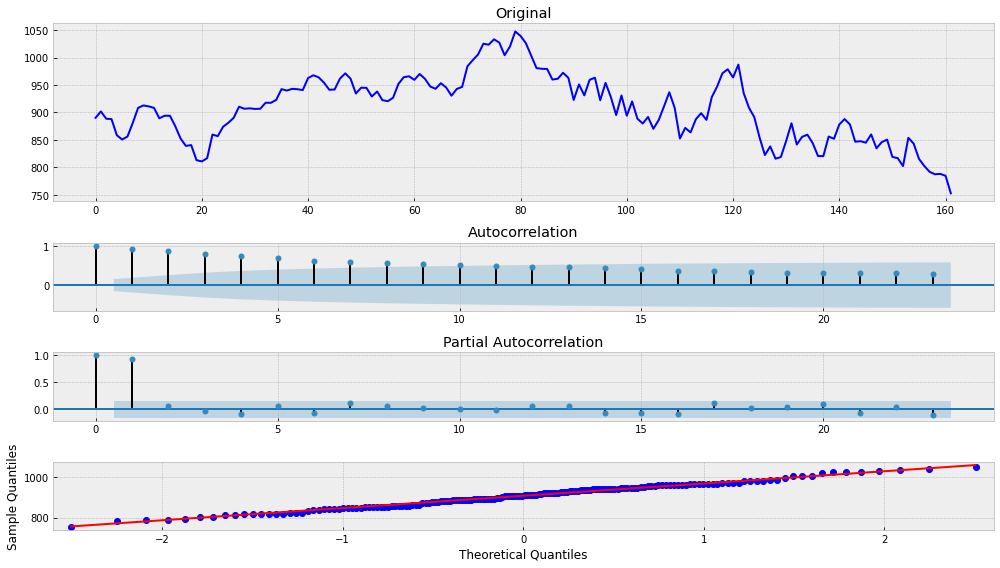

In [79]:
tsplot(series)

Делаем ряд стационарным

Results of Dickey-Fuller Test:
Test Statistic                  -5.598128
p-value                          0.000001
#Lags Used                       5.000000
Number of Observations Used    155.000000
Critical Value (1%)             -3.473259
Critical Value (5%)             -2.880374
Critical Value (10%)            -2.576812
dtype: float64


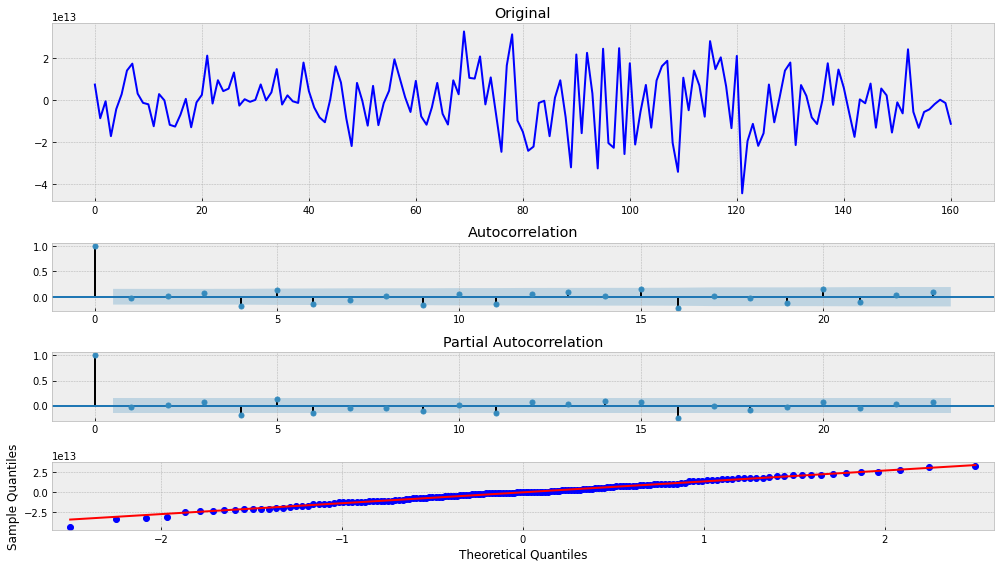

In [80]:
series = boxcox(series, 5)
series = series[1:] - series[:-1]
tsplot(series)

Подбираем гиперпараметры

aic: 10090.16046 | order: (2, 2, 4)
Results of Dickey-Fuller Test:
Test Statistic                -1.244203e+01
p-value                        3.734809e-23
#Lags Used                     0.000000e+00
Number of Observations Used    1.580000e+02
Critical Value (1%)           -3.472431e+00
Critical Value (5%)           -2.880013e+00
Critical Value (10%)          -2.576619e+00
dtype: float64


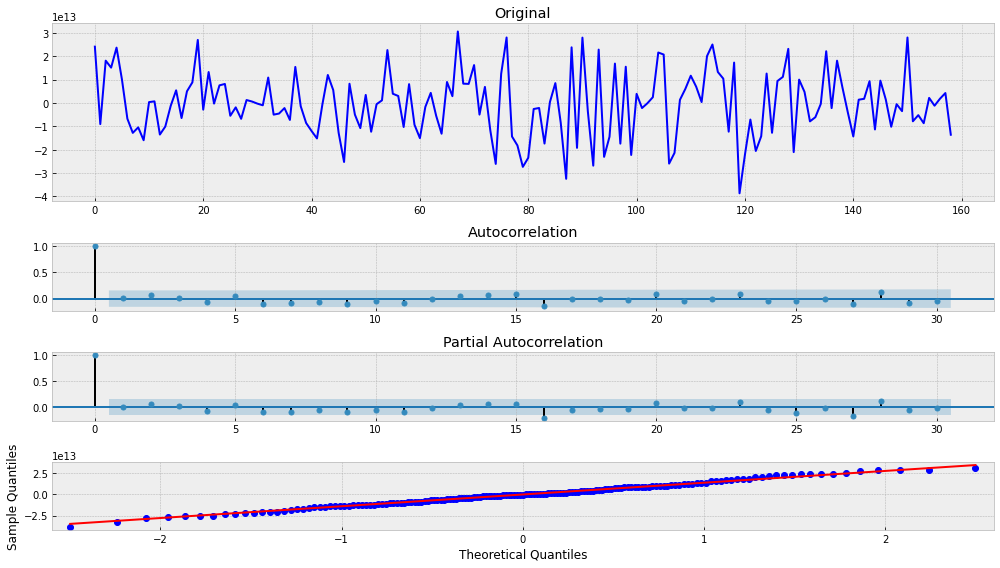

In [81]:
best_aic = np.inf 
best_order = None
best_mdl = None

for i in range(5):
    for d in range(5):
        for j in range(5):
            try:
                tmp_mdl = smt.ARIMA(series, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))


tsplot(best_mdl.resid, lags=30)

In [82]:
print(best_aic)
print(best_mdl)

10090.160461379313


Обучение модели

Results of Dickey-Fuller Test:
Test Statistic                -1.244203e+01
p-value                        3.734809e-23
#Lags Used                     0.000000e+00
Number of Observations Used    1.580000e+02
Critical Value (1%)           -3.472431e+00
Critical Value (5%)           -2.880013e+00
Critical Value (10%)          -2.576619e+00
dtype: float64


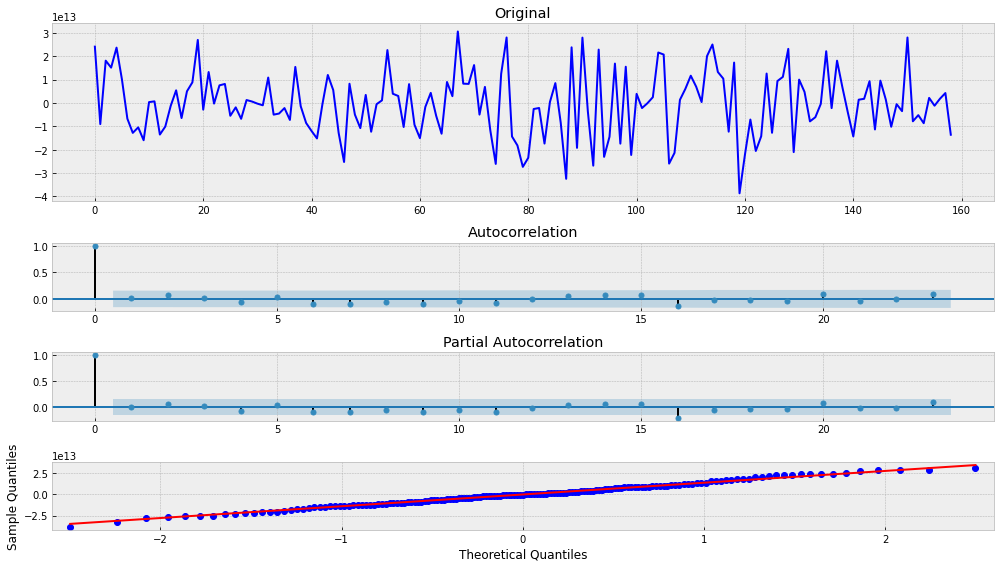

In [83]:
mdl = smt.ARIMA(series, order=(2, 2, 4)).fit(method='mle', trend='nc')
tsplot(mdl.resid)

Отрисовка прогнозов

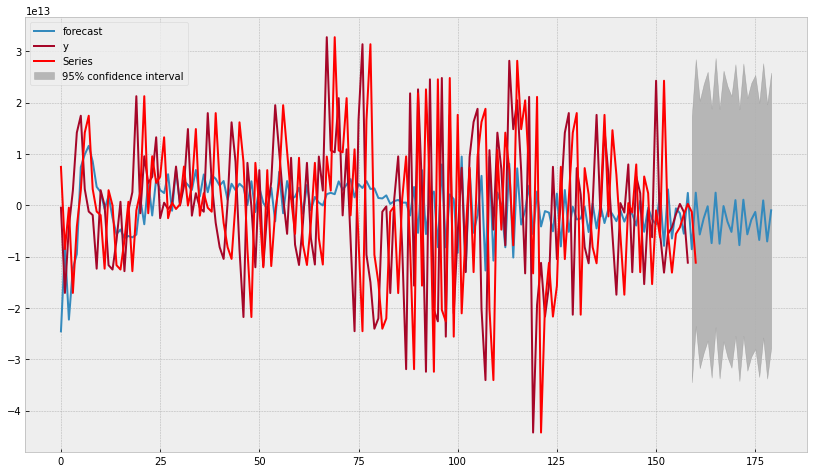

In [84]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    mdl.plot_predict(2, len(series)+20, ax=ax)
    plt.plot(series, color='red', label='Series')
    plt.legend()
    plt.show()

## Дополнительное задание

In [85]:
data = pd.read_csv('weekly-closings-of-the-dowjones-.csv')
data

,Week,Close
0,1971-W27,890.19
1,1971-W28,901.80
2,1971-W29,888.51
3,1971-W30,887.78
4,1971-W31,858.43
...,...,...
157,1974-W28,791.77
158,1974-W29,787.23
159,1974-W30,787.94
160,1974-W31,784.57


In [86]:
def prepareData(data, lag_start=5, lag_end=20, test_size=0.15):
    
    data = pd.DataFrame(data.copy())
    
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data)*(1-test_size))
    
    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.Close.shift(i)
        
    data = data.dropna()
    data = data.reset_index(drop=True)
    data = data.drop(["Week"], axis=1)
     
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["Close"], axis=1)
    y_train = data.loc[:test_index]["Close"]
    X_test = data.loc[test_index:].drop(["Close"], axis=1)
    y_test = data.loc[test_index:]["Close"]
    
    return X_train, X_test, y_train, y_test

In [87]:
X_train, X_test, y_train, y_test = prepareData(data, lag_start=1, lag_end=20, test_size=0.3)

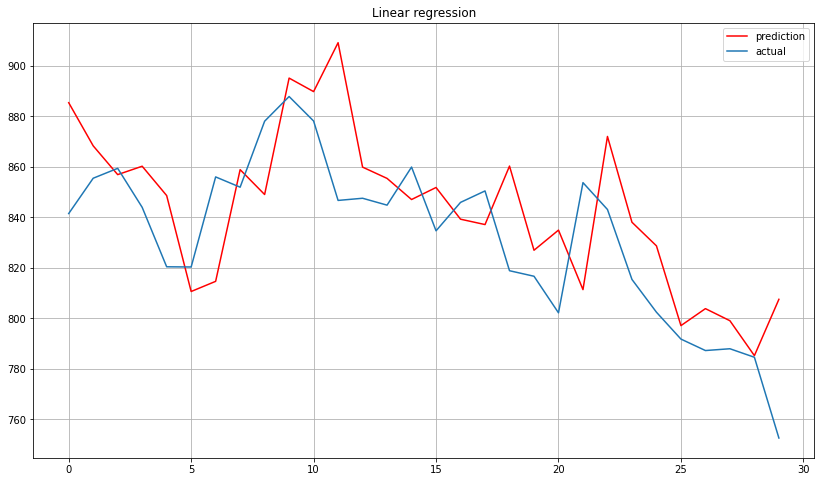

In [88]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)

plt.figure(figsize=(14, 8))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression")
plt.grid(True);

# International Airline Passengers

In [89]:
df = pd.read_csv('international-airline-passengers.csv')["Count"]
df.head()

0    112
1    118
2    132
3    129
4    121
Name: Count, dtype: int64

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


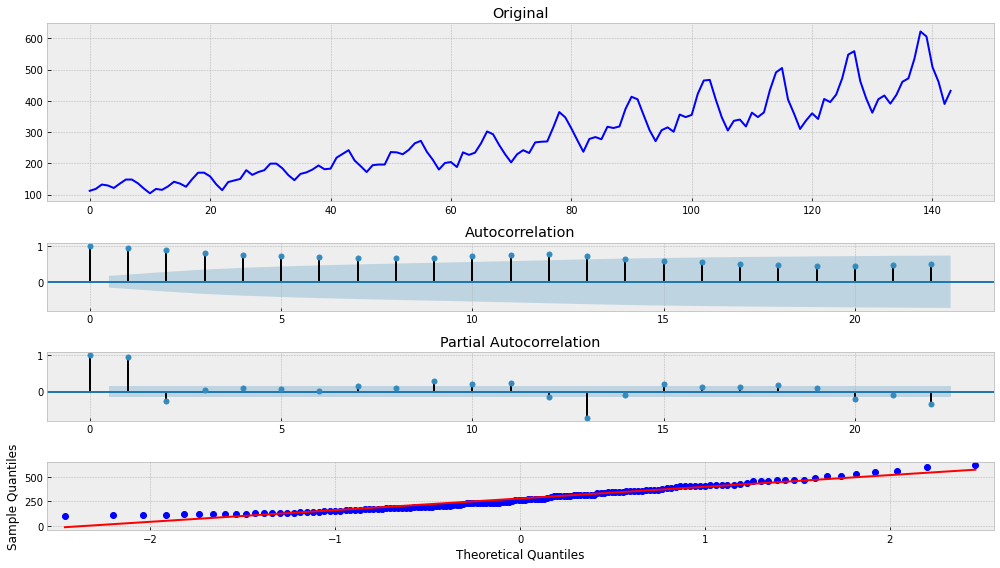

In [90]:
tsplot(df)

Results of Dickey-Fuller Test:
Test Statistic                  -4.443325
p-value                          0.000249
#Lags Used                      12.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64


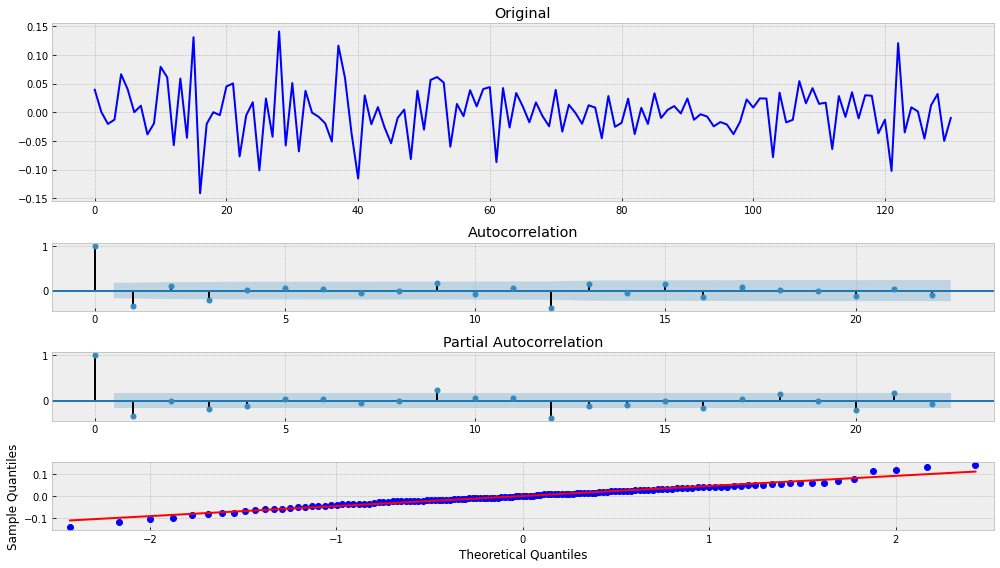

In [91]:
df = boxcox(df, 0)
df = df[12:] - df[:-12]
df = df[1:] - df[:-1]
tsplot(df)

aic: -461.63880 | order: (4, 0, 4)
Results of Dickey-Fuller Test:
Test Statistic                  -4.343392
p-value                          0.000373
#Lags Used                      11.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


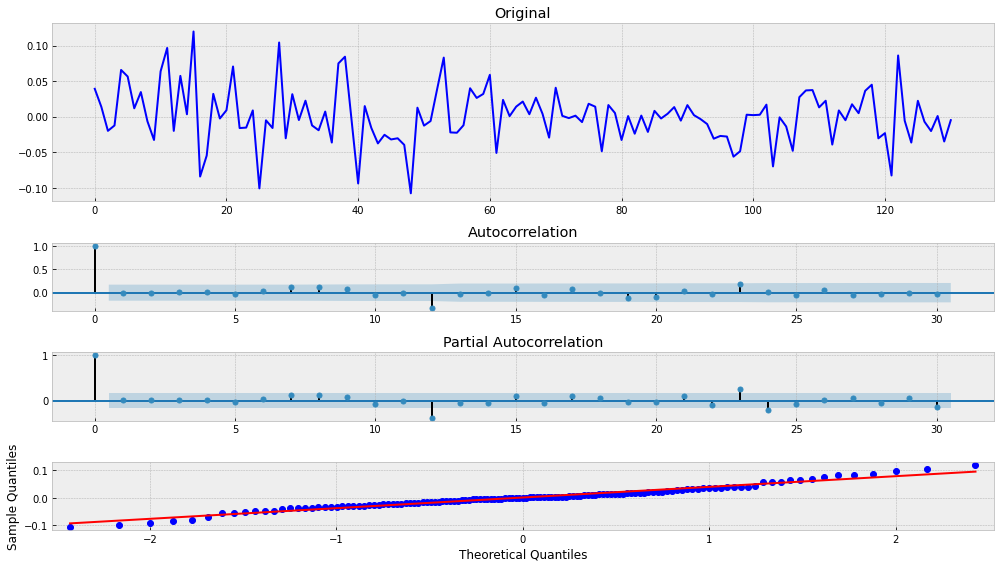

In [92]:
best_aic = np.inf 
best_order = None
best_mdl = None

for i in range(5):
    for d in range(5):
        for j in range(5):
            try:
                tmp_mdl = smt.ARIMA(df, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))


tsplot(best_mdl.resid, lags=30)

In [93]:
print(best_aic)
print(best_mdl)

-461.6388049186479


Results of Dickey-Fuller Test:
Test Statistic                  -4.343392
p-value                          0.000373
#Lags Used                      11.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


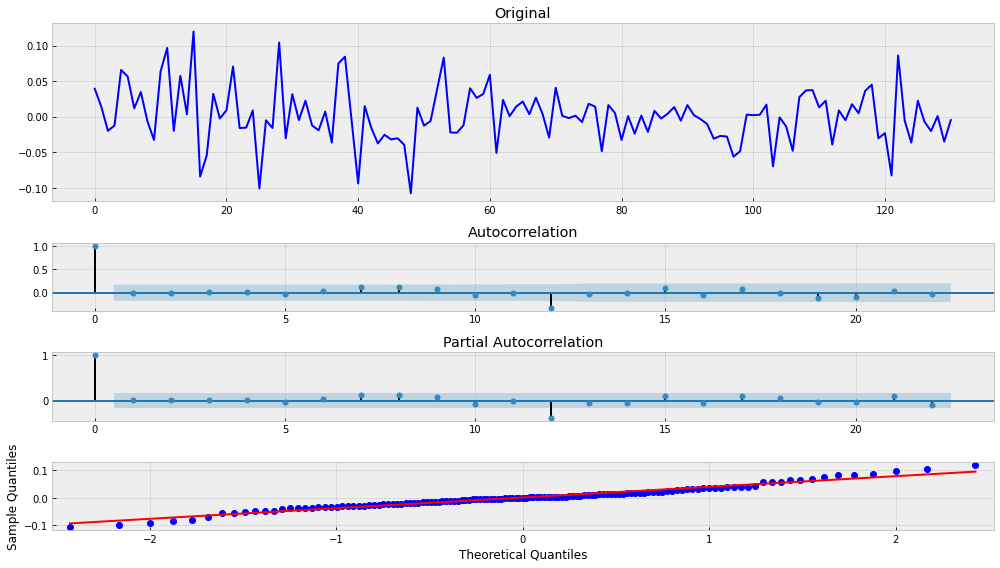

In [94]:
mdl = smt.ARIMA(df, order=(4,0,4)).fit(
                method='mle', trend='nc'
            )
tsplot(mdl.resid)

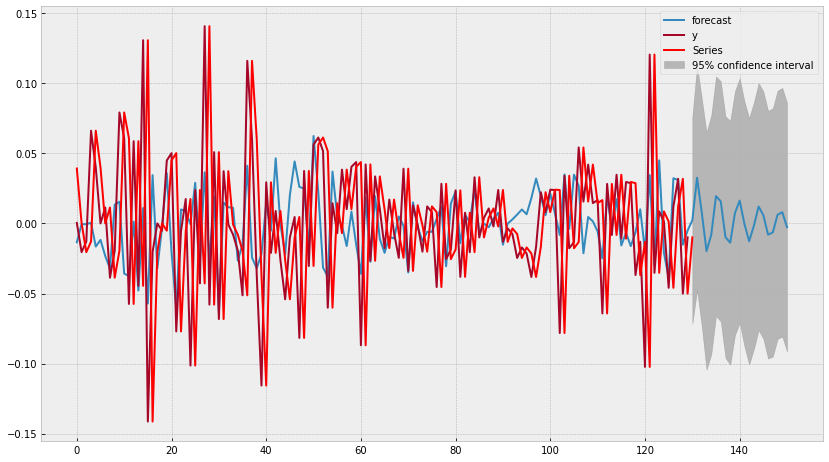

In [95]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    best_mdl.plot_predict(1, len(df)+20, ax=ax)
    plt.plot(df, color='red', label='Series')
    plt.legend()
    plt.show()